# Day 3: Transcriptomic Isoforms - Nanopore cDNA Sequencing Pipeline

## Bash Introduction
### Overview

This notebook demonstrates a bioinformatics pipeline designed to analyze nanopore cDNA sequencing data, specifically aimed at quantifying transcript isoforms and assessing alternative splicing events. The pipeline includes four main steps:

1. **Indexing reference genomes/transcriptomes** using `minimap2`.
2. **Read mapping** using `minimap2`, aligning nanopore sequencing reads to both a reference transcriptome (for quantification) and a reference genome (for visualization).
3. **Conversion to BAM format** with `samtools`, preparing alignment data for downstream analysis.
4. **Transcript quantification** using `salmon`, which estimates the abundance of transcript isoforms, particularly useful for alternative splicing analyses.


---


### Experimental Setup

The dataset used here comprises 12 barcoded samples divided into treatment groups and cellular fractions:

- **Barcode 01-03**: Nuclear fraction, exposed to light
- **Barcode 04-06**: Nuclear fraction, maintained in dark conditions
- **Barcode 07-09**: Cytoplasmic fraction, exposed to light
- **Barcode 10-12**: Cytoplasmic fraction, maintained in dark conditions

These groupings allow us to investigate the cellular localization and treatment effects on transcript isoform abundance and splicing patterns.


*Usually dorado basecaller outputs unmapped BAM files. In this case we will be directly using the FASTQ from the folder `/.../ONT_RNA_workshop/3.1_Transcriptomics/basecall/fastq_files/`*

---


### Basecalling and Demultiplexing (Previously Performed)

The raw nanopore sequencing data were basecalled and demultiplexed as follows:

*The dorado basecaller uses `.POD5` as input, so if you are using old sequencing data, `.fast5 -> .POD5` conversion should be performed.*
```bash
# Convert FAST5 to POD5 format
pod5 convert fast5 /path/to/fast5/*.fast5 --output /path/to/pod5/

# Basecalling with Dorado
# SQK-PCB109 is the sequencing kit name
# "sup" indicates the use of a high-accuracy basecalling model
dorado basecaller sup /path/to/pod5 --kit-name SQK-PCB109 --verbose -o /path/to/basecalling

# Barcode demultiplexing
# '--no-classify' is used since classification occurred during basecalling
dorado demux --output-dir /path/to/basecalling/barcodes --no-classify --emit-fastq /path/to/basecalling/basecalled_reads.bam
```

---

### Software
- MINIMAP2 - (https://github.com/lh3/minimap2)
- Samtools - (https://github.com/samtools/samtools)
- SALMON - (https://github.com/COMBINE-lab/salmon)
- SUPPA2 - (https://github.com/comprna/SUPPA)


---


### File Paths and Parameters

Define paths for input and output files and set parameters for computational efficiency:

*Here we are defining variables in bash programming laguage for latter use*

```bash
# Base directory - This is the directory from your local machine!
BASE_DIR="."

# Input directories and files
FASTQ_DIR="${BASE_DIR}/ONT_RNA_workshop/3.1_Transcriptomics/basecall/fastq_files/"
TRANSCRIPTOME_FA="{BASE_DIR}/ONT_RNA_workshop/Arabidopsis_references/transcriptome/AtRTDv2_1_QUASI.LS.fa"
GENOME_FA="{BASE_DIR}/ONT_RNA_workshop/Arabidopsis_references/genome/TAIR10_mod.fna"

# Indexes
MINIMAP2_INDEX_TRANSCRIPTOME="{BASE_DIR}/ONT_RNA_workshop/Arabidopsis_references/transcriptome/minimap2_index_transcriptome"
MINIMAP2_INDEX_GENOME="{BASE_DIR}/ONT_RNA_workshop/Arabidopsis_references/genome/minimap2_index_genome"

# Output directories
BAM_DIR_TRANSCRIPTOME="{BASE_DIR}/ONT_RNA_workshop/3.1_Transcriptomics/mapping/minimap2/transcriptome"
BAM_DIR_GENOME="{BASE_DIR}/ONT_RNA_workshop/3.1_Transcriptomics/mapping/minimap2/genome"
SALMON_DIR="{BASE_DIR}/ONT_RNA_workshop/3.1_Transcriptomics/mapping/salmon"

# Computational parameters (computers cores available)
THREADS=8
```

*In bash, this variables can be called by using a `$` before their name.*


**The `AtRTDv2_1_QUASI.LS` is a modified version of AtRTDv2_QUASI (https://ics.hutton.ac.uk/atRTD/)**


---

### Step-by-Step Processing Pipeline

#### Step 1: Indexing Reference Genome and Transcriptome
Create minimap2 indexes for efficient mapping.

*In Bash, including double quotes (" ") around variables is crucial for correct and safe handling of values, especially when they might contain spaces or special characters.*
```bash
minimap2 -d "$MINIMAP2_INDEX_TRANSCRIPTOME" "$TRANSCRIPTOME_FA"
minimap2 -d "$MINIMAP2_INDEX_GENOME" "$GENOME_FA"
```

#### Step 2: Prepare Output Directories
*`mkdir` creates the folder in the system, this is a safe practice to avoid errors if the directory is missing.*
```bash
mkdir -p "$BAM_DIR_TRANSCRIPTOME"
mkdir -p "$BAM_DIR_GENOME"
mkdir -p "$SALMON_DIR"
```

#### Step 3: Loop through each FASTQ file
- **Map reads to the transcriptome** for quantification.
- **Map reads to the genome** for visualization (e.g., IGV).
- **Convert alignments to BAM**.
- **Quantify isoforms with salmon**.

*This FOR LOOP iterates over each of the `.fastq` files from the `$FASTQ_DIR`.*

```bash
for FASTQ_FILE in "$FASTQ_DIR"/*.fastq; do
    FILENAME=$(basename "$FASTQ_FILE" .fastq)

    # Transcriptome alignment
    minimap2 -t $THREADS -a -x map-ont "$MINIMAP2_INDEX_TRANSCRIPTOME" "$FASTQ_FILE" | \
    samtools view -Sb > "$BAM_DIR_TRANSCRIPTOME/$FILENAME.bam"

    # Genome alignment
    minimap2 -t $THREADS -a -x splice "$MINIMAP2_INDEX_GENOME" "$FASTQ_FILE" | \
    samtools view -Sb > "$BAM_DIR_GENOME/$FILENAME.bam"

    # Quantification with salmon
    salmon quant --ont -p $THREADS \
        -t "$TRANSCRIPTOME_FA" \
        -l U \
        -a "$BAM_DIR_TRANSCRIPTOME/$FILENAME.bam" \
        -o "$SALMON_DIR/$FILENAME"
done
```

---

### Final Outputs

Results from this pipeline are essential for downstream analyses such as differential isoform expression, alternative splicing events, and visualization of splice variants.


# Coding time!

## Squiggle preview (What is nanopore measuring)

Let's start by peeking inside a POD5. This is the nanopore rawdata.
POD5 contain the measurements of each read when it passed through the pore. The measurement is in pico Amperes (pA), a current measure, and the variation on this signal is what the `dorado` basecalling models uses to predict which K-mer of bases was passing at the time.

To read this files (and see the signal) we will use the Nanopore POD5 library (https://pod5-file-format.readthedocs.io).

In [ ]:
import os, sys

# #Set path of the salmon files
# BASE_DIR = "/../"
# FAST5_EXAMPLE = os.path.join(BASE_DIR, "ONT_RNA_workshop", "ont_raw_data", "RNA")
# SALMON_DIR = os.path.join(BASE_DIR, "ONT_RNA_workshop", "3.1_Transcriptomics", "mapping", "salmon")
# OUTPUT_DIR = os.path.join(BASE_DIR, "ONT_RNA_workshop", "3.1_Transcriptomics", "outputs")

# This could be used if running the notebook locally (not in colab)

In [ ]:
# ⬇️ run this once; the rest of the cell is pure Python
!pip -q install pod5

In [ ]:
import pod5
import itertools, matplotlib.pyplot as plt
import pprint

In [ ]:

# ── 1) Describe the POD5 structure ───────────────────────────────────────────────────────────────
def describe_pod5(fpath, n_preview_fields=10):
    with pod5.Reader(fpath) as rdr:
        n_reads = rdr.num_reads
        print(f"\n📄  File : {fpath}")
        print(f"🧮  Total reads : {n_reads}")
        #
        first = next(rdr.reads())
        cols = [k for k in dir(first)
                if not k.startswith("_")
                and k != "signal"
                and not callable(getattr(first, k))]
        #
        print("📑  Columns :", ", ".join(cols) if cols else "(schema unavailable)")
        first = next(rdr.reads())
        keys = [k for k in dir(first) if not k.startswith("_") and k != "signal"]
        preview = {}
        for k in keys[:n_preview_fields]:
            v = getattr(first, k)
            if hasattr(v, "__len__") and not isinstance(v, (str, bytes)):
                preview[k] = f"<{type(v).__name__} len={len(v)}>"
            else:
                preview[k] = v
        print("🔍  First read metadata preview:")
        pprint.pprint(preview, compact=True, sort_dicts=False)
        print("\n")

# ── 2) LOAD the file as needed ───────────────────────────────────────────────────────────────
def load_first_reads(fpath, n=2):
    with pod5.Reader(fpath) as rdr:
        traces = [(str(r.read_id), r.signal)
                    for r in itertools.islice(rdr.reads(), n)]
    ylabel = "Signal (pA)"
    return traces, ylabel

# ── 3) PLOT ───────────────────────────────────────────────────────────────
def plot_squiggles(traces, ylabel):
    """
    Draw one subplot per trace where
        traces = [(read_id, signal), ...]
    """
    print("# Plotting The electric signal:\n")
    fig, axes = plt.subplots(len(traces), 1, figsize=(12, 3*len(traces)))
    if len(traces) == 1:                        # matplotlib quirk
        axes = [axes]
    for ax, (rid, sig) in zip(axes, traces):
        ax.plot(sig, lw=0.5)
        ax.set_title(f"Read: {rid}")
        ax.set_xlabel("Sample index")
        ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()



In [ ]:
from google.colab import files
# Small snippet to upload a file to colab.
# Load the .POD5 sample file
uploaded = files.upload()

In [ ]:
# Brief POD5 description
describe_pod5('sample_20reads.pod5')

# Read and parse the POD5 file
traces, ylab = load_first_reads('sample_20reads.pod5', n=2)

# students can explore `traces` here, e.g. print(len(traces[0][1]))
plot_squiggles(traces, ylabel=ylab)

---

## Data analysis

Now it's time for coding! This script is intented as a guide to help you load the data from SALMON to have some insights on the data.

In [ ]:
# Libraries to handle files from the system
import os, sys
# Library to load dataframes, filter and parse data
import pandas as pd  # 'as pd' works as an alias for the pandas library (common practice)

### Loading SALMON Output.

Since SALMON outputs one folder for each sample we want to extract only the `quant.sf` from each dir.

The following script copies every quant.sf file and renames it as the containing folder name (You can copy and paste this script to the terminal):

*Remember to define the base directory!*

```bash
BASE_DIR="."

# Input directory containing all barcode folders
INPUT_DIR="${BASE_DIR}/ONT_RNA_workshop/3.1_Transcriptomics/mapping/salmon"

# Output directory to store renamed quant.sf files
OUTPUT_DIR="${BASE_DIR}/ONT_RNA_workshop/3.1_Transcriptomics/mapping/salmon/colab_quant_files"
echo "$OUTPUT_DIR"
# Create the output directory if it doesn't exist
mkdir -p "$OUTPUT_DIR"

# Find and copy each quant.sf file
find "$INPUT_DIR" -type f -name "quant.sf" | while read filepath; do
    # Get the folder name containing the quant.sf
    folder_name=$(basename "$(dirname "$filepath")")
    
    # Define new filename and destination
    new_filename="${folder_name}.sf"
    cp "$filepath" "$OUTPUT_DIR/$new_filename"
    
    echo "Copied $filepath to $OUTPUT_DIR/$new_filename"
done

echo "✅ All quant.sf files copied and renamed."

```

*(Paste on the terminal using Ctrl+Shift+V)*

Feel free to inspect the `quant.sf` file.

You can do this open it with a regular text editor (slower).

Or using the terminal command: `$ less quant.sf` (just loads on memory the part it's showing).

In [ ]:
from google.colab import files
# List SALMON quant files:
# /.../ONT_RNA_workshop/3.1_Transcriptomics/mapping/salmon/colab_quant_files
# Upload all the .sf files together (hold Ctrl/Cmd to select multiple)
uploaded = files.upload()

In [ ]:
import pandas as pd
from io import StringIO

# Build a new list for TPM-only dataframes
tpm_tables = []

for i in range(12):
    barcode_number = ("0" + str(i+1)) if i < 9 else i+1
    filename = f"SQK-PCB109_barcode{barcode_number}_chr3.sf"
    sample_name = filename.split("_")[1].replace(".sf", "")     # Get the name from the filename
    df = pd.read_csv(filename, sep='\t')  # Load each table as a pandas df
    df = df.set_index('Name')                                   # Set the isoform 'Name' as index

    tpm = df[['TPM']].rename(columns={'TPM': sample_name})      # Keep only TPM column and rename it to sample name
    tpm_tables.append(tpm)

tpm_combined = pd.concat(tpm_tables, axis=1)                    # Merge all dataframes (TPM)
tpm_combined["Gene"] = tpm_combined.index.str.slice(0, 9)       # Extract gene name for later grouping

# Sorting the columns (just for clearer prints)  :)
barcode_order = [
    "barcode01", "barcode02", "barcode03", "barcode04", "barcode05", "barcode06",
    "barcode07", "barcode08", "barcode09", "barcode10", "barcode11", "barcode12"
]
sorted_columns = ['Gene'] + barcode_order
tpm_combined = tpm_combined[sorted_columns]

tpm_combined.head()     # .head() command prints the first rows

**✅ All Samples Loaded**

We have successfully loaded all the samples into a single DataFrame, where each row represents a transcript (identified by its `Name`), and each column corresponds to a different sample.

This unified format allows us to easily compare transcript expression levels **across samples** and **search for specific genes of interest**.

---

### 📊 About SALMON Outputs

Salmon provides two key metrics for transcript quantification:

- **NumReads**: the estimated number of reads assigned to each transcript.
- **TPM (Transcripts Per Million)**: a normalized measure of transcript abundance that accounts for both sequencing depth and transcript length.

Unlike raw read counts, **TPMs are directly comparable across samples**, making them especially useful for visualization and interpretation.

> 🔍 In this notebook, we'll focus on **TPM values** to explore expression patterns between conditions or samples.


In [ ]:
gene_of_interest = "AT3G61860"
tpm_combined[tpm_combined["Gene"] == gene_of_interest]

## Alternative-splicing quantification on chr3 with SUPPA 2

We will:

1. **Install SUPPA 2** (https://github.com/comprna/SUPPA)
2. **Generate alternative-splicing events** from the _AtRTDv2_ chr3 GTF  
3. **Build a transcript-TPM matrix** from the 12 Salmon quantifications  
4. **Compute PSI (Ψ) values per event** across all samples  

> **Paths used below**  
> *GTF* : `/.../ONT_RNA_workshop/Arabidopsis_references/transcriptome/AtRTDv2_1_QUASI_chr3.gtf`  
> *Salmon outputs* : `/.../ONT_RNA_workshop/3.1_Transcriptomics/mapping/salmon/colab_quant_files/*.sf`  
> Adjust if you placed the files somewhere else (e.g. Google Drive).

---

### 1) Install SUPPA 2
Suppa2 can be easily installed like this:
```bash
pip install --quiet suppa==2.3
````

But since the last version (2.4) is still not pip installable, we have cloned suppa repository to the `tools` folder.

Inside suppa folder, look for the `suppa.py` file!

`/.../ONT_RNA_workshop/tools/SUPPA-2.4/suppa.py`

###############################################

\### **REPLACE THE `/.../` FOR THE PROPER DIRECTORY!** ####
###############################################

---

### 2) Generate splicing-event annotation (`.ioi`)

```bash
python /.../ONT_RNA_workshop/tools/SUPPA-2.4/suppa.py generateEvents \
    -i /.../ONT_RNA_workshop/Arabidopsis_references/transcriptome/AtRTDv2_1_QUASI_chr3.gtf \
    -o AtRTDv2_chr3 \
    -f ioi
```

Creates `AtRTDv2_chr3.ioi` file

---

## 3) Build the transcript-TPM matrix *from the Pandas DataFrame you already loaded*

> We have a DataFrame named **`tpm_combined`** where  
> &nbsp;&nbsp;• the *index* = **transcript IDs** (e.g. `AT3G01040.1`)  
> &nbsp;&nbsp;• the first column = **gene ID** (optional for SUPPA)  
> &nbsp;&nbsp;• the remaining 12 columns = TPM values for each barcode sample  
>   
> SUPPA’s `psiPerEvent` just needs a **tab-separated file** whose first column is the
> transcript ID and the header row lists the sample names.  
> We can write it straight from the DataFrame:


In [ ]:
# Keep the index and the 'Gene' column
#base_cols = ['Name']

# Define barcode groups
groups = {
    'Nuc_light': ['barcode01', 'barcode02', 'barcode03'],
    'Nuc_dark': ['barcode04', 'barcode05', 'barcode06'],
    'Cit_light': ['barcode07', 'barcode08', 'barcode09'],
    'Cit_dark': ['barcode10', 'barcode11', 'barcode12']
}

# Split and store
df_groups = {}
for group_name, barcodes in groups.items():
    df_groups[group_name] = tpm_combined[barcodes] # base_cols +

for group_name, sub_df in df_groups.items():
    sub_df.to_csv(f"{group_name}_TPM.tsv", sep='\t', index=True)


*Look for the file on the right panel of Colab. It's under the folder Icon*

**<--- (Check for the file on the left and download it!)**


---

### 4) Compute Ψ for each isoform (IOI)

```bash
python /.../ONT_RNA_workshop/tools/SUPPA-2.4/suppa.py psiPerIsoform \
  -g AtRTDv2_chr3.ioi \
  -e Nuc_light.tsv \
  -o Nuc_light
````

Output **`Nuc_light.psi`**
*Rows* = transcripts  *Columns* = 12 barcodes  *Values* = Ψ (isoform usage).

---

### 5) Compare light vs dark nuclei (group-comparison)

The command below performs an **empirical group comparison** (`-gc`) between the
*light* and *dark* nuclei conditions, using:

* **Input annotation** `AtRTDv2_chr3.ioi`
* **Per-condition Ψ matrices** `Nuc_light_TPM_isoform.psi` and `Nuc_dark_TPM_isoform.psi`
* **Per-condition TPM tables** `Nuc_light_TPM.tsv` and `Nuc_dark_TPM.tsv`
* **Sliding-window area** `--area 500` (recommended default)

```bash
SUPPA="/.../ONT_RNA_workshop/3.1_Transcriptomics/SUPPA2/"
    
python /.../ONT_RNA_workshop/tools/SUPPA-2.4/suppa.py diffSplice \
    -m empirical --combination -th 1 \
    --input "${SUPPA}AtRTDv2_chr3.ioi" \
    --psi "${SUPPA}psi/Nuc_light_TPM_isoform.psi" "${SUPPA}psi/Nuc_dark_TPM_isoform.psi" "${SUPPA}psi/Cit_light_TPM_isoform.psi" "${SUPPA}psi/Cit_dark_TPM_isoform.psi" \
    --tpm "${SUPPA}per_condition_dataframe/Nuc_light_TPM.tsv" "${SUPPA}per_condition_dataframe/Nuc_dark_TPM.tsv" "${SUPPA}per_condition_dataframe/Cit_light_TPM.tsv" "${SUPPA}per_condition_dataframe/Cit_dark_TPM.tsv" \
    --area 500 -gc -o "${SUPPA}comparisons/nuc_cit_light_dark"
```

**Output** `light_dark.dpsi` (and related files):

| Column                 | Meaning                                    |
| ---------------------- | ------------------------------------------ |
| `gene_id` / `event_id` | Gene or transcript being tested            |
| `dpsi`                 | ΔΨ between conditions                      |
| `p_value`              | Raw empirical p-value                      |
| `adj_p_value`          | Benjamini–Hochberg FDR (already corrected) |

---

### (Quick check of the comparison)

```bash
head -n 5 /.../ONT_RNA_workshop/3.1_Transcriptomics/SUPPA2/comparisons/light_dark.dpsi | column -t
```

You now have **differential isoform-usage** results ready for downstream
visualisation (volcano plots, heatmaps) or functional enrichment.

---


### Loading the differential isoform usage comparison

Now we wil dive into the SUPPA2 output and make some plots!

First of all lest check for the genes with the biggest alternative splicing variations:

In [ ]:
import pandas as pd

# Load the file: "/.../ONT_RNA_workshop/3.1_Transcriptomics/SUPPA2/comparisons/nuc_cit_light_dark.dpsi"
uploaded = files.upload()
SUPPA_FILE = next(iter(uploaded))

Let's create a nice dataframe splitting gene name and isoforms

In [ ]:
df_suppa = pd.read_csv(SUPPA_FILE, sep = "\t")
df_suppa.rename(columns=lambda c: c.replace('_TPM_isoform', ''), inplace=True)
display(df_suppa.head())
# Split the index and create 'gene' and 'isoform' columns
df_suppa.index = df_suppa.index.str.split(';', expand=True)
df_suppa.index.names = ['Gene', 'Transcript']
print("Now with the new gene/isoform index")
df_suppa

We can organize each of the outputs, splitting them into new dataframes (saved into a python dictionary)

In [ ]:
# 1) pull out the base names of each comparison (strip trailing _dPSI / _p-val)
comparisons = sorted({c.rsplit("_", 1)[0] for c in df_suppa.columns})
# 2) build a dict of “tidy” data-frames: {comparison: 2-column DF}
split_dfs = {
    cmp: df_suppa[[f"{cmp}_dPSI", f"{cmp}_p-val"]].rename(
            columns={f"{cmp}_dPSI": "dPSI", f"{cmp}_p-val": "p_val"})
    for cmp in comparisons
}

# Optional: save each to TSV (Tab Separated Values)

# for cmp, sub in split_dfs.items():
#     sub.to_csv(f"{cmp}.tsv", sep="\t")
#     print("✅", cmp, "→", f"{cmp}.tsv")

# Quick access example
nuc_light_vs_dark = split_dfs["Nuc_light-Nuc_dark"]
nuc_light_vs_dark.head()

In [ ]:
# @title p_val

from matplotlib import pyplot as plt
nuc_light_vs_dark['p_val'].plot(kind='hist', bins=20, title='p_val')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Creating a filter for significant values

We will set 2 thresholds:
- dpsi_cut: We will consider that variation on the psi less than 0.1 are irrelevant (or noise)
- p-value_cut: Only keep the changes that are significant (< 0.05)

In [ ]:
# --- All the comparisons made ----------------------------------
contrasts = [
    "Nuc_light-Nuc_dark",
    "Nuc_light-Cit_light",
    "Nuc_light-Cit_dark",
    "Nuc_dark-Cit_light",
    "Nuc_dark-Cit_dark",
    "Cit_light-Cit_dark",
]
dpsi_cut  = 0.10           # |ΔPSI| threshold
p_cut     = 0.05           # raw p threshold  (see §8 for FDR)

# -------------------------------------------------------------

sig = {
    c: (
        df_suppa[f"{c}_p-val"]   <= p_cut
     ) & (
        df_suppa[f"{c}_dPSI"].abs() >= dpsi_cut
     ) & (
        df_suppa[f"{c}_dPSI"].abs() < 1             # We also want to remove the
     )
    for c in contrasts
}

'''
This filter can be improved by filtering the GENES with at least one
significant value change. (you can try it!)
Suggestion: use .groupby() and take advantage of the multiindex
'''

### Some Plots to review the data!

How can we explore the results from the SUPPA2 comparison.
This is up to your biological question, but here are some ideas you can try  
:)

In [ ]:
import numpy as np

#### Volcano plot

In [ ]:
def volcano_plot(contrast, ax=None):
    x = df_suppa[f"{contrast}_dPSI"]
    y = -np.log10(df_suppa[f"{contrast}_p-val"])
    ax = ax or plt.gca()
    ax.scatter(x, y, s=8, alpha=.6,
               c=sig[contrast].map({True:"red", False:"grey"}))
    ax.axvline( dpsi_cut, ls="--"); ax.axvline(-dpsi_cut, ls="--")
    ax.axhline(-np.log10(p_cut), ls="--")
    ax.set_xlabel("ΔPSI"); ax.set_ylabel("-log10 p-value")
    ax.set_title(f"Volcano • {contrast}")

volcano_plot("Nuc_light-Cit_light")
plt.show()

#### Cluster map

In [ ]:
import seaborn as sns
dpsi_cols = [c for c in df_suppa.columns if c.endswith("_dPSI")]

# Drop rows with NaN values in the dPSI columns and fill any remaining non-finite values with 0
df_suppa_cleaned = df_suppa.dropna(subset=dpsi_cols).fillna(0)

import seaborn as sns
dpsi_cols = [f"{c}_dPSI" for c in contrasts]
sns.clustermap(
    df_suppa_cleaned[dpsi_cols],
    cmap="vlag", center=0,
    figsize=(10, 8),
    yticklabels=False
)
plt.show()

#### Venn diagram

I think this is one of best way to show the amount of change that happened in each condition. Here I picked just 3, but you can *Venn diagram* as much as you like!

You may need to explore different libraries for more complex venn diagrams (4, 5 or more groups)

**Here we show the amount of genes that changed their splicing proportions in 3 different comparisons**

In [ ]:
# pip install matplotlib-venn
from matplotlib_venn import venn3

set1 = set(df_suppa.index[sig["Nuc_dark-Cit_dark"]])
set2 = set(df_suppa.index[sig["Nuc_light-Cit_light"]])
set3 = set(df_suppa.index[sig["Nuc_light-Nuc_dark"]])

labels = ("Nuc D ↔ Cit D", "Nuc L ↔ Cit L", "Nuc L ↔ Cit D")

venn3([set1, set2, set3], set_labels=labels)
plt.title("Significant ΔPSI | Venn diagram")
plt.show()


#### Pair plot

Visually explore relationships between multiple variables. It compares ΔPSI (delta Percent Spliced In) values between various conditions or contrasts.

In [ ]:
import itertools, seaborn as sns
pair_cols = [f"{c}_dPSI" for c in contrasts]

sns.pairplot(df_suppa[pair_cols], corner=True,
             plot_kws=dict(s=8, alpha=.5))
plt.suptitle("ΔPSI cross-contrast scatter matrix", y=1.02)
plt.show()

In [ ]:
import numpy as np # Import numpy for arange
import matplotlib.pyplot as plt # Import matplotlib

# --- recalc the two series -------------------------------------------------
counts_up   = [(df_suppa[f"{c}_dPSI"] >  dpsi_cut).sum()  for c in contrasts]
counts_down = [(df_suppa[f"{c}_dPSI"] < -dpsi_cut).sum()  for c in contrasts]
counts_down = [-n for n in counts_down]   # negate so bars extend downward

# --- plot ------------------------------------------------------------------
x = np.arange(len(contrasts))
fig, ax = plt.subplots()

ax.bar(x, counts_up,             label="+ΔPSI")         # upward bars
ax.bar(x, counts_down,           label="-ΔPSI")         # downward bars
ax.axhline(0, color="k", lw=1)                          # zero reference

ax.set_xticks(x, contrasts, rotation=45, ha="right")
ax.set_ylabel("# significant events")
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
# pip install tabulate  (pretty console tables)

import pandas as pd
from tabulate import tabulate
# ------------------------------------------------------------------
# 1.  Load your SUPPA2 data  (already done if df_suppa exists)
# df_suppa = pd.read_csv("arabidopsis_suppa_output.tsv", sep="\t", index_col=0)

# 2.  Identify ΔPSI columns
dpsi_cols = [c for c in df_suppa.columns if c.endswith("_dPSI")]

# 3 a.  ---  ISOFORM-LEVEL ranking  --------------------------------
df_iso = df_suppa.copy()
df_iso["max_abs_dPSI"] = df_iso[dpsi_cols].abs().max(axis=1)

top_iso = (
    df_iso
    .sort_values("max_abs_dPSI", ascending=False)
    .head(20)                                    # change to any N you like
    [["max_abs_dPSI"] + dpsi_cols]
    .round(3)
)

print("\nTop isoforms by |ΔPSI| in any contrast")
print(tabulate(top_iso, headers="keys", tablefmt="github"))


### Inspecting the data!
Let's go back to the TPMs and inspect what is SUPPA2 telling us!

In [ ]:
gene_of_interest = "AT3G61860"
display(tpm_combined[tpm_combined["Gene"] == gene_of_interest])

display(df_suppa.loc[(gene_of_interest, )])

In [ ]:
df_transposed = tpm_combined[tpm_combined["Gene"] == gene_of_interest].T

# Exclude the 'Gene' row before performing numerical operations
df_normalized = df_transposed.drop('Gene').div(df_transposed.drop('Gene').sum(axis=1), axis=0).fillna(0)

# Plot normalized stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_normalized.plot(kind='bar', stacked=True, ax=ax)

# Customize plot
ax.set_xlabel('Barcode')
ax.set_ylabel('Proportion of Total Expression')
ax.set_title(f'Proportional Expression of {gene_of_interest} Isoforms Across Barcodes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
alpha = 0.05
gene  = "AT3G61860"

# ----- slice the gene first -----
df_gene = df_suppa.xs(gene, level="Gene")     # MultiIndex ➜ Gene level

# ----- same logic as before, but on df_gene -----
pval_cols   = [c for c in df_gene.columns if c.endswith("_p-val")]
cols_to_drop = []

for pcol in pval_cols:
    prefix = pcol.rsplit("_", 1)[0]           # strip "_p-val"
    if (df_gene[pcol] >= alpha).all():        # none significant in this gene
        cols_to_drop += [f"{prefix}_dPSI", pcol]

df_sig = df_gene.drop(columns=cols_to_drop)
display(df_sig)

In [ ]:
# prompt: Using dataframe df_sig: suggest a plot

import altair as alt

# Reshape the dataframe to a long format for plotting
# Reset the index to make 'Transcript' a column
df_long = df_gene.reset_index().melt('Transcript', var_name='condition', value_name='value')

# Separate the conditions and metrics
df_long[['condition', 'metric']] = df_long['condition'].str.rsplit('_', n=1, expand=True)

# Filter for dPSI values
df_dpsi = df_long[df_long['metric'] == 'dPSI']

# Create a bar chart
chart = alt.Chart(df_dpsi).mark_bar().encode(
    x=alt.X('condition:N', title='Condition'),  # X-axis by condition
    y=alt.Y('value:Q', title='dPSI Value'),  # Y-axis for dPSI value
    color='condition:N', # Color by condition
    column=alt.Column('Transcript:N', header=alt.Header(titleOrient="bottom", labelOrient="bottom"), title='Transcript') # Separate columns for each transcript
).properties(
    title='dPSI Values by Transcript and Condition' # Chart title
)

chart

We can see the isoforms here: https://boxify.boku.ac.at/

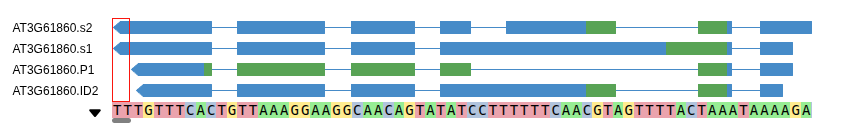

## IGV - Visualizing the reads
### Let's use the genome browser!

Finally let's check this gene on the genome browser.

#### IGV (Integrative Genomics Viewer)

Open the terminal and type `igv`

**Load the genome:**

Open `Genomes` -> `Load Genome from File...` and search for our reference genome: `/../ONT_RNA_workshop/Arabidopsis_references/genome/TAIR10_chr3.fna`

**Load the annotations:**

Open `File` -> `Load from File...` and search for our reference annotations: `/.../ONT_RNA_workshop/Arabidopsis_references/transcriptome/AtRTDv2_1_QUASI_chr3.gtf`

**Load the BAM files:**
*We should use the files mapped to the genome (NOT the transcriptome)*
Open `File` -> `Load from File...` and search for our mapped BAMS on: `/.../ONT_RNA_workshop/3.1_Transcriptomics/mapping/minimap2/genome/`

 -- You can try with one, but IGV requests the BAMs **sorted** and **indexed** --

We included a small script in the bam fodler that sorts and indexes our files. Look for `index_and_sort_bams.sh` from the terminal, be sure to execute it within the bam folder where the BAM files are placed!


In [ ]:
alpha = 0.05                     # significance threshold

# 1️⃣  columns that hold p-values
pval_cols = [c for c in df_suppa.columns if c.endswith('_p-val')]

# 2️⃣  Boolean matrix: True where p < alpha
sig_bool = df_suppa[pval_cols].lt(alpha)          # lt = “less than”

# 3️⃣  Aggregate by Gene (first level of the MultiIndex)
#     • .groupby(level='Gene') keeps transcripts separate inside each gene
#     • .sum() counts how many True values we had
gene_sig_counts = sig_bool.groupby(level='Gene').sum()

# 4️⃣  Optional: overall total per gene across all comparisons
gene_sig_counts['total_sig'] = gene_sig_counts.sum(axis=1)

# 5️⃣  Pick the top N genes
top_genes = gene_sig_counts.sort_values('total_sig', ascending=False)

display(top_genes.head(10))

Let's check:

- AT3G61860
- AT3G50670
- AT3G58560
- AT3G26510 (comment on reads per sample)
- AT3G23050
